# 🚗 Car Brand Classification with EfficientNet-B4

Bu proje, **Akbank Derin Öğrenme Bootcamp** kapsamında geliştirilmiştir.  
Amaç: 33 farklı araç markasını CNN tabanlı bir model ile sınıflandırmaktır.  

**Model:** EfficientNet-B4 (ImageNet pretrained)  
**Veri Seti:** [Car Brand Classification Dataset](https://www.kaggle.com/datasets/ahmedelsany/car-brand-classification-dataset)  

In [1]:
import os, random, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# GPU kontrolü
print("GPU:", tf.config.list_physical_devices("GPU"))

# Reprodüksiyon için sabit seed
SEED=42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# Mixed precision (hız + VRAM optimizasyonu)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# Dataset path
ROOT = Path("/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset")
train_dir, val_dir, test_dir = ROOT/"train", ROOT/"val", ROOT/"test"

# Parametreler
IMG_SIZE=(380,380)
BATCH=16
AUTOTUNE=tf.data.AUTOTUNE

2025-09-24 09:15:35.967490: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758705336.134668      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758705336.187805      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory as idfd

class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
NUM_CLASSES = len(class_names)
print("Classes:", NUM_CLASSES)

train_ds = idfd(train_dir, image_size=IMG_SIZE, batch_size=BATCH,
                label_mode="int", shuffle=True, seed=SEED, class_names=class_names)
val_ds   = idfd(val_dir,   image_size=IMG_SIZE, batch_size=BATCH,
                label_mode="int", shuffle=False, seed=SEED, class_names=class_names)
test_ds  = idfd(test_dir,  image_size=IMG_SIZE, batch_size=BATCH,
                label_mode="int", shuffle=False, seed=SEED, class_names=class_names)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

Classes: 33
Found 11517 files belonging to 33 classes.


I0000 00:00:1758705351.116226      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2475 files belonging to 33 classes.
Found 2475 files belonging to 33 classes.


In [3]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.25),
    layers.RandomTranslation(0.1, 0.1),
], name="augmentation")

In [4]:
base = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE+(3,)
)
base.trainable = False

inp = keras.Input(IMG_SIZE+(3,))
x = data_aug(inp)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = keras.Model(inp, out)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cbs_warm = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-7),
    keras.callbacks.ModelCheckpoint("/kaggle/working/best_warmup.keras",
                                    monitor="val_accuracy", save_best_only=True)
]

hist = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=cbs_warm)

Epoch 1/15


E0000 00:00:1758705389.385977      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758705392.572738      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


720/720 ━━━━━━━━━━━━━━━━━━━━ 185s 206ms/step - accuracy: 0.0388 - loss: 3.5668 - val_accuracy: 0.0853 - val_loss: 3.3664 - learning_rate: 1.0000e-04
Epoch 2/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 139s 193ms/step - accuracy: 0.0678 - loss: 3.4285 - val_accuracy: 0.1329 - val_loss: 3.2622 - learning_rate: 1.0000e-04
Epoch 3/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 139s 193ms/step - accuracy: 0.0941 - loss: 3.3415 - val_accuracy: 0.1459 - val_loss: 3.1903 - learning_rate: 1.0000e-04
Epoch 4/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 138s 192ms/step - accuracy: 0.1115 - loss: 3.2842 - val_accuracy: 0.1564 - val_loss: 3.1407 - learning_rate: 1.0000e-04
Epoch 5/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 138s 192ms/step - accuracy: 0.1226 - loss: 3.2418 - val_accuracy: 0.1685 - val_loss: 3.0987 - learning_rate: 1.0000e-04
Epoch 6/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 139s 192ms/step - accuracy: 0.1292 - loss: 3.1948 - val_accuracy: 0.1786 - val_loss: 3.0678 - learning_rate: 1.0000e-04
Epoch 7/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 139s 194ms/

In [6]:
base.trainable = True
for l in base.layers[:-200]:
    l.trainable = False

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

cbs_ft = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3, min_lr=1e-7),
    keras.callbacks.ModelCheckpoint("/kaggle/working/best_finetune.keras",
                                    monitor="val_accuracy", save_best_only=True)
]

hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=cbs_ft)

Epoch 1/40


E0000 00:00:1758707543.674854      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


720/720 ━━━━━━━━━━━━━━━━━━━━ 318s 346ms/step - accuracy: 0.1354 - loss: 3.2097 - val_accuracy: 0.2085 - val_loss: 2.9341 - learning_rate: 1.0000e-05
Epoch 2/40
720/720 ━━━━━━━━━━━━━━━━━━━━ 240s 333ms/step - accuracy: 0.1765 - loss: 3.0228 - val_accuracy: 0.2448 - val_loss: 2.7919 - learning_rate: 1.0000e-05
Epoch 3/40
720/720 ━━━━━━━━━━━━━━━━━━━━ 240s 333ms/step - accuracy: 0.2175 - loss: 2.8647 - val_accuracy: 0.2844 - val_loss: 2.6542 - learning_rate: 1.0000e-05
Epoch 4/40
720/720 ━━━━━━━━━━━━━━━━━━━━ 240s 334ms/step - accuracy: 0.2506 - loss: 2.7435 - val_accuracy: 0.3248 - val_loss: 2.5132 - learning_rate: 1.0000e-05
Epoch 5/40
720/720 ━━━━━━━━━━━━━━━━━━━━ 240s 334ms/step - accuracy: 0.2946 - loss: 2.6151 - val_accuracy: 0.3596 - val_loss: 2.3869 - learning_rate: 1.0000e-05
Epoch 6/40
720/720 ━━━━━━━━━━━━━━━━━━━━ 240s 334ms/step - accuracy: 0.3225 - loss: 2.4841 - val_accuracy: 0.3919 - val_loss: 2.2621 - learning_rate: 1.0000e-05
Epoch 7/40
720/720 ━━━━━━━━━━━━━━━━━━━━ 240s 333ms/

In [7]:
print("Test accuracy:", model.evaluate(test_ds, verbose=0)[1])

Test accuracy: 0.7171717286109924


In [8]:
import os, tensorflow as tf
from tensorflow import keras

CKPT = "/kaggle/working/best_finetune.keras"
best = keras.models.load_model(CKPT, compile=False) if os.path.exists(CKPT) else model
best.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
)
print("Val (top1, top5):", best.evaluate(val_ds,  verbose=0))
print("Test (top1, top5):", best.evaluate(test_ds, verbose=0))

Val (top1, top5): [1.0772011280059814, 0.7288888692855835, 0.8804040551185608]
Test (top1, top5): [1.0747650861740112, 0.7171717286109924, 0.8852525353431702]


In [13]:
import tensorflow as tf

def accuracy_tta(model, ds, times=4):
    m1 = tf.keras.metrics.SparseCategoricalAccuracy()
    m5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)

    augs = [
        lambda x: x,
        tf.image.flip_left_right,
        lambda x: tf.image.rot90(x, 1),
        lambda x: tf.image.central_crop(x, 0.9),  # bu boyutu küçültür
    ]

    for x, y in ds:
        preds = []
        for f in augs[:times]:
            xx = f(x)
            # ⬇️ her zaman hedef boyuta geri getir
            xx = tf.image.resize(xx, IMG_SIZE)       # IMG_SIZE = (380,380)
            preds.append(model(xx, training=False))
        p = tf.reduce_mean(tf.stack(preds, axis=0), axis=0)
        m1.update_state(y, p); m5.update_state(y, p)

    return float(m1.result().numpy()), float(m5.result().numpy())

               precision    recall  f1-score   support

        Acura     0.6957    0.6400    0.6667        75
 Aston Martin     0.7667    0.9200    0.8364        75
         Audi     0.8551    0.7867    0.8194        75
          BMW     0.6438    0.6267    0.6351        75
      Bentley     0.6168    0.8800    0.7253        75
        Buick     0.5859    0.7733    0.6667        75
     Cadillac     0.7143    0.8000    0.7547        75
    Chevrolet     0.6452    0.5333    0.5839        75
     Chrysler     0.7816    0.9067    0.8395        75
        Dodge     0.8500    0.6800    0.7556        75
         FIAT     0.7907    0.9067    0.8447        75
         Ford     0.6889    0.4133    0.5167        75
          GMC     0.7500    0.8800    0.8098        75
        Honda     0.5165    0.6267    0.5663        75
      Hyundai     0.5968    0.4933    0.5401        75
     INFINITI     0.6951    0.7600    0.7261        75
       Jaguar     0.6825    0.5733    0.6232        75
         

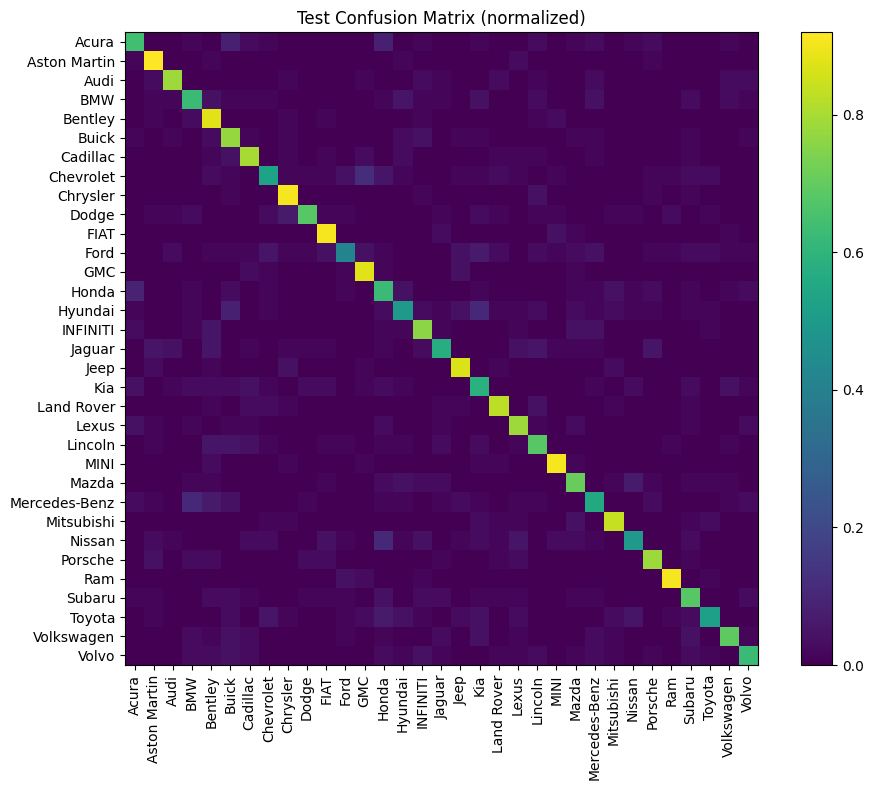

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_prob = best.predict(test_ds, verbose=0)
y_pred = y_prob.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-9)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(cmn, interpolation="nearest"); plt.title("Test Confusion Matrix (normalized)")
plt.colorbar(); plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names); plt.tight_layout(); plt.show()

In [30]:
def gradcam(model, img_uint8, img_size=(380,380)):
    # Görüntüyü hazırla
    x = tf.image.resize(img_uint8, img_size)[None, ...]
    x = tf.cast(x, tf.float32)
    x = tf.keras.applications.efficientnet.preprocess_input(x)

    # EfficientNetB4 base modelini çek
    base_model = model.get_layer("efficientnetb4")
    conv_layer = base_model.get_layer("top_conv")   # son conv katmanı

    # Ara model: input → [feature map, prediction]
    grad_model = Model(inputs=model.input,
                       outputs=[conv_layer.output, model.output])

    # Grad-CAM hesabı
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x, training=False)
        cls = tf.argmax(preds[0])     
        score = preds[:, cls]         

    grads = tape.gradient(score, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))

    conv = conv_out[0]
    heat = tf.reduce_sum(tf.multiply(pooled, conv), axis=-1).numpy()
    heat = np.maximum(heat, 0) / (heat.max() + 1e-8)
    heat = cv2.resize(heat, img_size[::-1])

    return heat, int(cls.numpy())

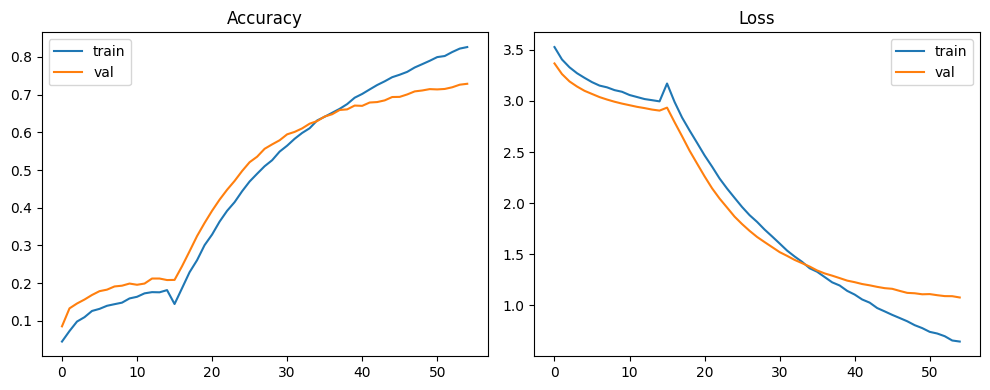

In [31]:
def plot_histories(*histories):
    acc=val_acc=loss=val_loss=[]
    acc=[]; val_acc=[]; loss=[]; val_loss=[]
    for h in histories:
        if h is None: continue
        acc     += h.history.get("accuracy", [])
        val_acc += h.history.get("val_accuracy", [])
        loss    += h.history.get("loss", [])
        val_loss+= h.history.get("val_loss", [])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(acc); plt.plot(val_acc); plt.title("Accuracy"); plt.legend(["train","val"])
    plt.subplot(1,2,2); plt.plot(loss); plt.plot(val_loss); plt.title("Loss"); plt.legend(["train","val"])
    plt.tight_layout(); plt.show()

try: plot_histories(hist, hist_ft)
except NameError: plot_histories(hist)

In [22]:
best.save("/kaggle/working/effnetb4_carbrand_final.keras")
print("Saved to /kaggle/working/effnetb4_carbrand_final.keras")

Saved to /kaggle/working/effnetb4_carbrand_final.keras
